# Modern Hopfield Networks: A Powerful Associative Memory Model

## Introduction
Modern Hopfield Networks are advanced versions of the classic Hopfield Network (1982), designed to overcome its limitations while retaining its core strengths in **associative memory** and **pattern retrieval**. These networks have gained renewed attention due to their connections to **attention mechanisms** in deep learning.

## Key Features
- **Continuous-valued patterns** (unlike binary states in classical version)
- **Exponential memory capacity** (scales with dimension)
- **Energy-minimizing dynamics** guarantees convergence
- **Mathematically equivalent** to Transformer attention

## Mathematical Formulation

### Energy Function
The energy of a state `ξ` with stored patterns `X = [x₁, ..., xₙ]` is:

E(ξ; X) = -lse(β, Xᵀξ) + (1/2)ξᵀξ + C


Where:
- `lse(β,z) = (1/β)log(∑exp(βzᵢ))` (log-sum-exp)
- `β` is the inverse temperature parameter
- `C` is a constant

### Update Rule
The retrieval dynamics follow:

ξ_new = X·softmax(βXᵀξ_old)

*This is identical to the attention mechanism in Transformers when X represents keys/values.*

## Advantages Over Classical Hopfield

| Feature          | Classical           | Modern              |
|------------------|---------------------|---------------------|
| **State Space**  | Binary (±1)         | Continuous (ℝᵈ)     |
| **Capacity**     | O(0.138n) patterns  | O(exp(d)) patterns  |
| **Interference** | High                | Low                 |
| **Applications** | Limited             | Broad (including DL)|

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

class ModernHopfield:
    def __init__(self, dim, beta=1.0):
        self.dim = dim          # Input dimension
        self.beta = beta        # Inverse temperature parameter (controls pattern separation)
        self.memory = None      # Stored pattern matrix (dxn)
    
    def store(self, patterns):
        """Store continuous-valued patterns"""
        self.memory = np.array(patterns).T  # Convert to dxn matrix
        
    def retrieve(self, query, max_iter=10):
        """Retrieve patterns from noisy input (handles continuous data)"""
        current = query.copy()
        energy_history = []
        
        for _ in range(max_iter):
            # Modern Hopfield update rule
            similarity = self.beta * self.memory.T @ current
            weights = np.exp(similarity - np.max(similarity))  # Numerically stable softmax
            weights = weights / np.sum(weights)
            current = self.memory @ weights
            
            # Record energy
            energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.dot(current, current)
            energy_history.append(energy)
            
        return current, energy_history
    
    def energy(self, x):
        """Compute energy for any state x"""
        similarity = self.beta * self.memory.T @ x
        return -np.log(np.sum(np.exp(similarity))) + 0.5 * np.dot(x, x)

## Generate train data

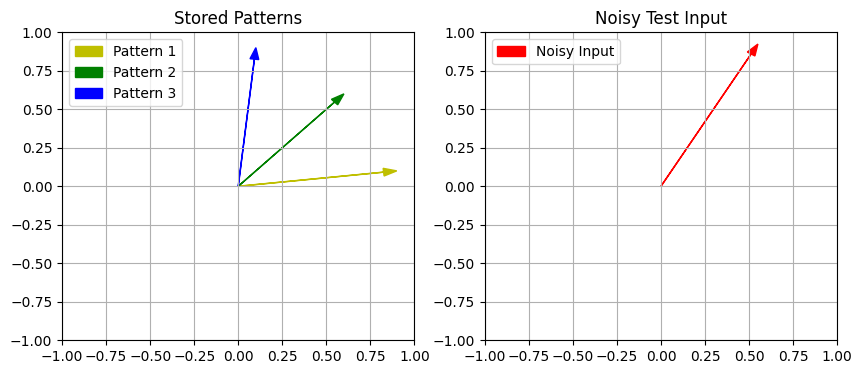

In [11]:
# Generate 3 interfering 2D continuous patterns (intentionally similar)
pattern_A = np.array([0.9, 0.1])  # Primarily along x-axis
pattern_B = np.array([0.6, 0.6])  # Diagonal (interferes with A/B)
pattern_C = np.array([0.1, 0.9])  # Primarily along y-axis

patterns = [pattern_A, pattern_B, pattern_C]

colors = ['y', 'g', 'b']

# Visualize stored patterns
plt.figure(figsize=(10, 4))
plt.subplot(121)
for i, p in enumerate(patterns):
    plt.arrow(0, 0, p[0], p[1], head_width=0.05, length_includes_head=True, color=colors[i], label=f'Pattern {i+1}')
plt.xlim(-1, 1); plt.ylim(-1, 1); plt.grid(); plt.legend()
plt.title("Stored Patterns")

# Add noisy test data
noisy_B = pattern_B + np.random.normal(0, 0.2, size=2)
noisy_B = noisy_B / np.linalg.norm(noisy_B)  # Normalize

plt.subplot(122)
plt.arrow(0, 0, noisy_B[0], noisy_B[1], head_width=0.05, color='r', label='Noisy Input')
plt.xlim(-1, 1); plt.ylim(-1, 1); plt.grid(); plt.legend()
plt.title("Noisy Test Input")
plt.show()

## Training and Testing

Noisy Input: [0.47 0.88]
Retrieved: [0.27 0.79]
Closest Pattern: Pattern 3


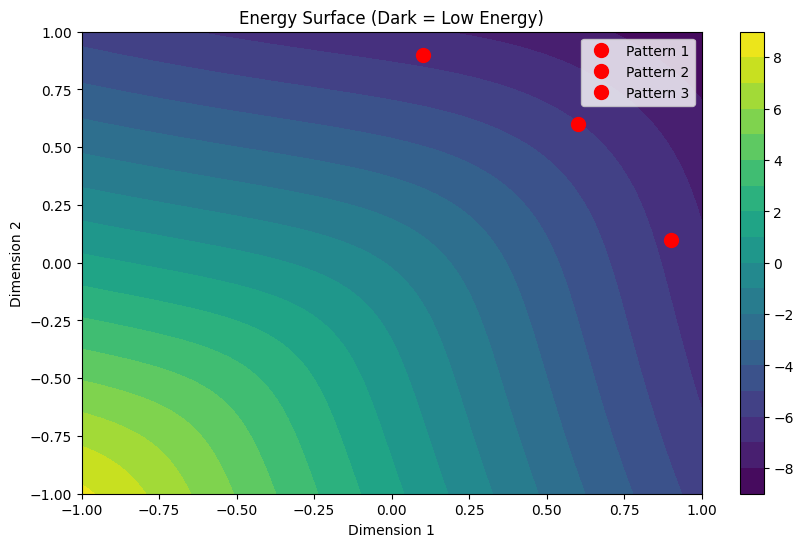

In [9]:
# Initialize network
network = ModernHopfield(dim=2, beta=8.0)  # High beta enhances pattern separation
network.store(patterns)

# Test 1: Recover original pattern from noisy input
retrieved, energy_history = network.retrieve(noisy_B)

print(f"Noisy Input: {noisy_B.round(2)}")
print(f"Retrieved: {retrieved.round(2)}")
print(f"Closest Pattern: Pattern {np.argmax([np.dot(retrieved, p) for p in patterns]) + 1}")

# Test 2: Energy surface visualization (shows pattern separation)
def plot_energy_surface():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = network.energy(np.array([X[i,j], Y[i,j]]))
    
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    for i, p in enumerate(patterns):
        plt.plot(p[0], p[1], 'ro', markersize=10, label=f'Pattern {i+1}')
    plt.colorbar()
    plt.title("Energy Surface (Dark = Low Energy)")
    plt.xlabel("Dimension 1"); plt.ylabel("Dimension 2")
    plt.legend()

plot_energy_surface()